In [53]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
import matplotlib.gridspec as gridspec
import jax.numpy as jnp
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.hamiltonian as ham

In [54]:
@jax.jit
def H_analytical_2D(q, p, m1=1.0, m2=1.0, k1=1.0, k2=1.0):
    # q, p shape: (..., 2)  例: (13, 2500, 2)
    
    # スライスを使って次元を維持したまま成分を取り出す
    # [..., 0] は「最後の次元の0番目」という意味です
    q1 = q[..., 0]
    q2 = q[..., 1]
    p1 = p[..., 0]
    p2 = p[..., 1]

    # これで (13, 2500) の形状同士の計算になります
    T = 0.5 / m1 * (p1 - p2)**2 + 0.5 / m2 * p2**2
    V = 0.5 * k1 * q1**2 + 0.5 * k2 * q2**2
    
    return T + V

In [55]:
# MSE計算 (各質点ごとに計算)
def calc_mse_mass_individual(q_pred, p_pred, q_ref, p_ref):
    """
    Input: (N, T, 2)
    Output: mse_m1 (N, T), mse_m2 (N, T)
    """
    # Mass 1 (index 0)
    err_q1 = (q_pred[..., 0] - q_ref[..., 0])**2
    err_p1 = (p_pred[..., 0] - p_ref[..., 0])**2
    mse_m1 = (err_q1 + err_p1) / 2.0
    
    # Mass 2 (index 1)
    err_q2 = (q_pred[..., 1] - q_ref[..., 1])**2
    err_p2 = (p_pred[..., 1] - p_ref[..., 1])**2
    mse_m2 = (err_q2 + err_p2) / 2.0
    
    return mse_m1, mse_m2

In [56]:
# 相対エネルギー誤差 (平均なし)
def calc_relative_energy_error_traj(E_pred, E_true):
    epsilon = 1e-10
    return np.abs((E_pred - E_true) / (np.abs(E_true) + epsilon))

In [57]:
def calculate_mse_dim(q_pred, p_pred, q_true, p_true, dim):
    return (q_pred[:, dim] - q_true[:, dim])**2 + (p_pred[:, dim] - p_true[:, dim])**2

In [58]:
# --- 保存したデータをロード ---
data_lnn = np.load("results_H2D_LNN.npz")
data_hnn = np.load("results_H2D_HNN.npz")
data_bnn_h = np.load("results_H2D_NN_h.npz")
data_bnn_l = np.load("results_H2D_NN_l.npz")

t_eval = data_hnn['t_true_hnn'][0]
q_true = data_hnn['q_true_hnn']
p_true = data_hnn['p_true_hnn']

# HNN系
q_hnn = data_hnn['q_learned_hnn']
p_hnn = data_hnn['p_learned_hnn']
q_lnn_from_hnn = data_hnn['q_learned_lnn_from_hnn']
p_lnn_from_hnn = data_hnn['p_learned_lnn_from_hnn']

# LNN系
q_lnn = data_lnn['q_learned_lnn']
p_lnn = data_lnn['p_learned_lnn']
q_hnn_from_lnn = data_lnn['q_learned_hnn_from_lnn']
p_hnn_from_lnn = data_lnn['p_learned_hnn_from_lnn']

# Baseline
q_bnn_h = data_bnn_h['q_learned']
p_bnn_h = data_bnn_h['p_learned']
q_bnn_l = data_bnn_l['q_learned']
p_bnn_l = data_bnn_l['p_learned']

# --- 3. 指標計算 ---

# (A) MSE (Mass 1 & Mass 2 Separate)
# Returns tuple (mse_m1, mse_m2)
mse_hnn_m1, mse_hnn_m2 = calc_mse_mass_individual(q_hnn, p_hnn, q_true, p_true)
mse_hnn_from_lnn_m1, mse_hnn_from_lnn_m2 = calc_mse_mass_individual(q_hnn_from_lnn, p_hnn_from_lnn, q_true, p_true)

mse_lnn_m1, mse_lnn_m2 = calc_mse_mass_individual(q_lnn, p_lnn, q_true, p_true)
mse_lnn_from_hnn_m1, mse_lnn_from_hnn_m2 = calc_mse_mass_individual(q_lnn_from_hnn, p_lnn_from_hnn, q_true, p_true)

mse_bnn_h_m1, mse_bnn_h_m2 = calc_mse_mass_individual(q_bnn_h, p_bnn_h, q_true, p_true)
mse_bnn_l_m1, mse_bnn_l_m2 = calc_mse_mass_individual(q_bnn_l, p_bnn_l, q_true, p_true)


# (B) Energy (Total System)
E_true = H_analytical_2D(q_true, p_true)
E_hnn = H_analytical_2D(q_hnn, p_hnn)
E_hnn_from_lnn = H_analytical_2D(q_hnn_from_lnn, p_hnn_from_lnn)
E_lnn = H_analytical_2D(q_lnn, p_lnn)
E_lnn_from_hnn = H_analytical_2D(q_lnn_from_hnn, p_lnn_from_hnn)
E_bnn_h = H_analytical_2D(q_bnn_h, p_bnn_h)
E_bnn_l = H_analytical_2D(q_bnn_l, p_bnn_l)

# (C) Energy Relative Error
err_E_hnn = calc_relative_energy_error_traj(E_hnn, E_true)
err_E_hnn_from_lnn = calc_relative_energy_error_traj(E_hnn_from_lnn, E_true)
err_E_lnn = calc_relative_energy_error_traj(E_lnn, E_true)
err_E_lnn_from_hnn = calc_relative_energy_error_traj(E_lnn_from_hnn, E_true)
err_E_bnn_h = calc_relative_energy_error_traj(E_bnn_h, E_true)
err_E_bnn_l = calc_relative_energy_error_traj(E_bnn_l, E_true)


# --- 4. 平均値計算 (内挿データのみ) ---
N_interp = 10 

def calc_mean_interp(arr):
    return np.mean(arr[:N_interp], axis=0)

# Mass 1 Mean MSE
mse_mean_hnn_m1 = calc_mean_interp(mse_hnn_m1)
mse_mean_hnn_fl_m1 = calc_mean_interp(mse_hnn_from_lnn_m1)
mse_mean_lnn_m1 = calc_mean_interp(mse_lnn_m1)
mse_mean_lnn_fh_m1 = calc_mean_interp(mse_lnn_from_hnn_m1)
mse_mean_bnn_h_m1 = calc_mean_interp(mse_bnn_h_m1)
mse_mean_bnn_l_m1 = calc_mean_interp(mse_bnn_l_m1)

# Mass 2 Mean MSE
mse_mean_hnn_m2 = calc_mean_interp(mse_hnn_m2)
mse_mean_hnn_fl_m2 = calc_mean_interp(mse_hnn_from_lnn_m2)
mse_mean_lnn_m2 = calc_mean_interp(mse_lnn_m2)
mse_mean_lnn_fh_m2 = calc_mean_interp(mse_lnn_from_hnn_m2)
mse_mean_bnn_h_m2 = calc_mean_interp(mse_bnn_h_m2)
mse_mean_bnn_l_m2 = calc_mean_interp(mse_bnn_l_m2)

# Energy Error Mean
err_mean_hnn = calc_mean_interp(err_E_hnn)
err_mean_hnn_fl = calc_mean_interp(err_E_hnn_from_lnn)
err_mean_lnn = calc_mean_interp(err_E_lnn)
err_mean_lnn_fh = calc_mean_interp(err_E_lnn_from_hnn)
err_mean_bnn_h = calc_mean_interp(err_E_bnn_h)
err_mean_bnn_l = calc_mean_interp(err_E_bnn_l)

/var/folders/54/vv15yr8537zbdx1vcsrpv0sm0000gn/T/ipykernel_47295/4233645160.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


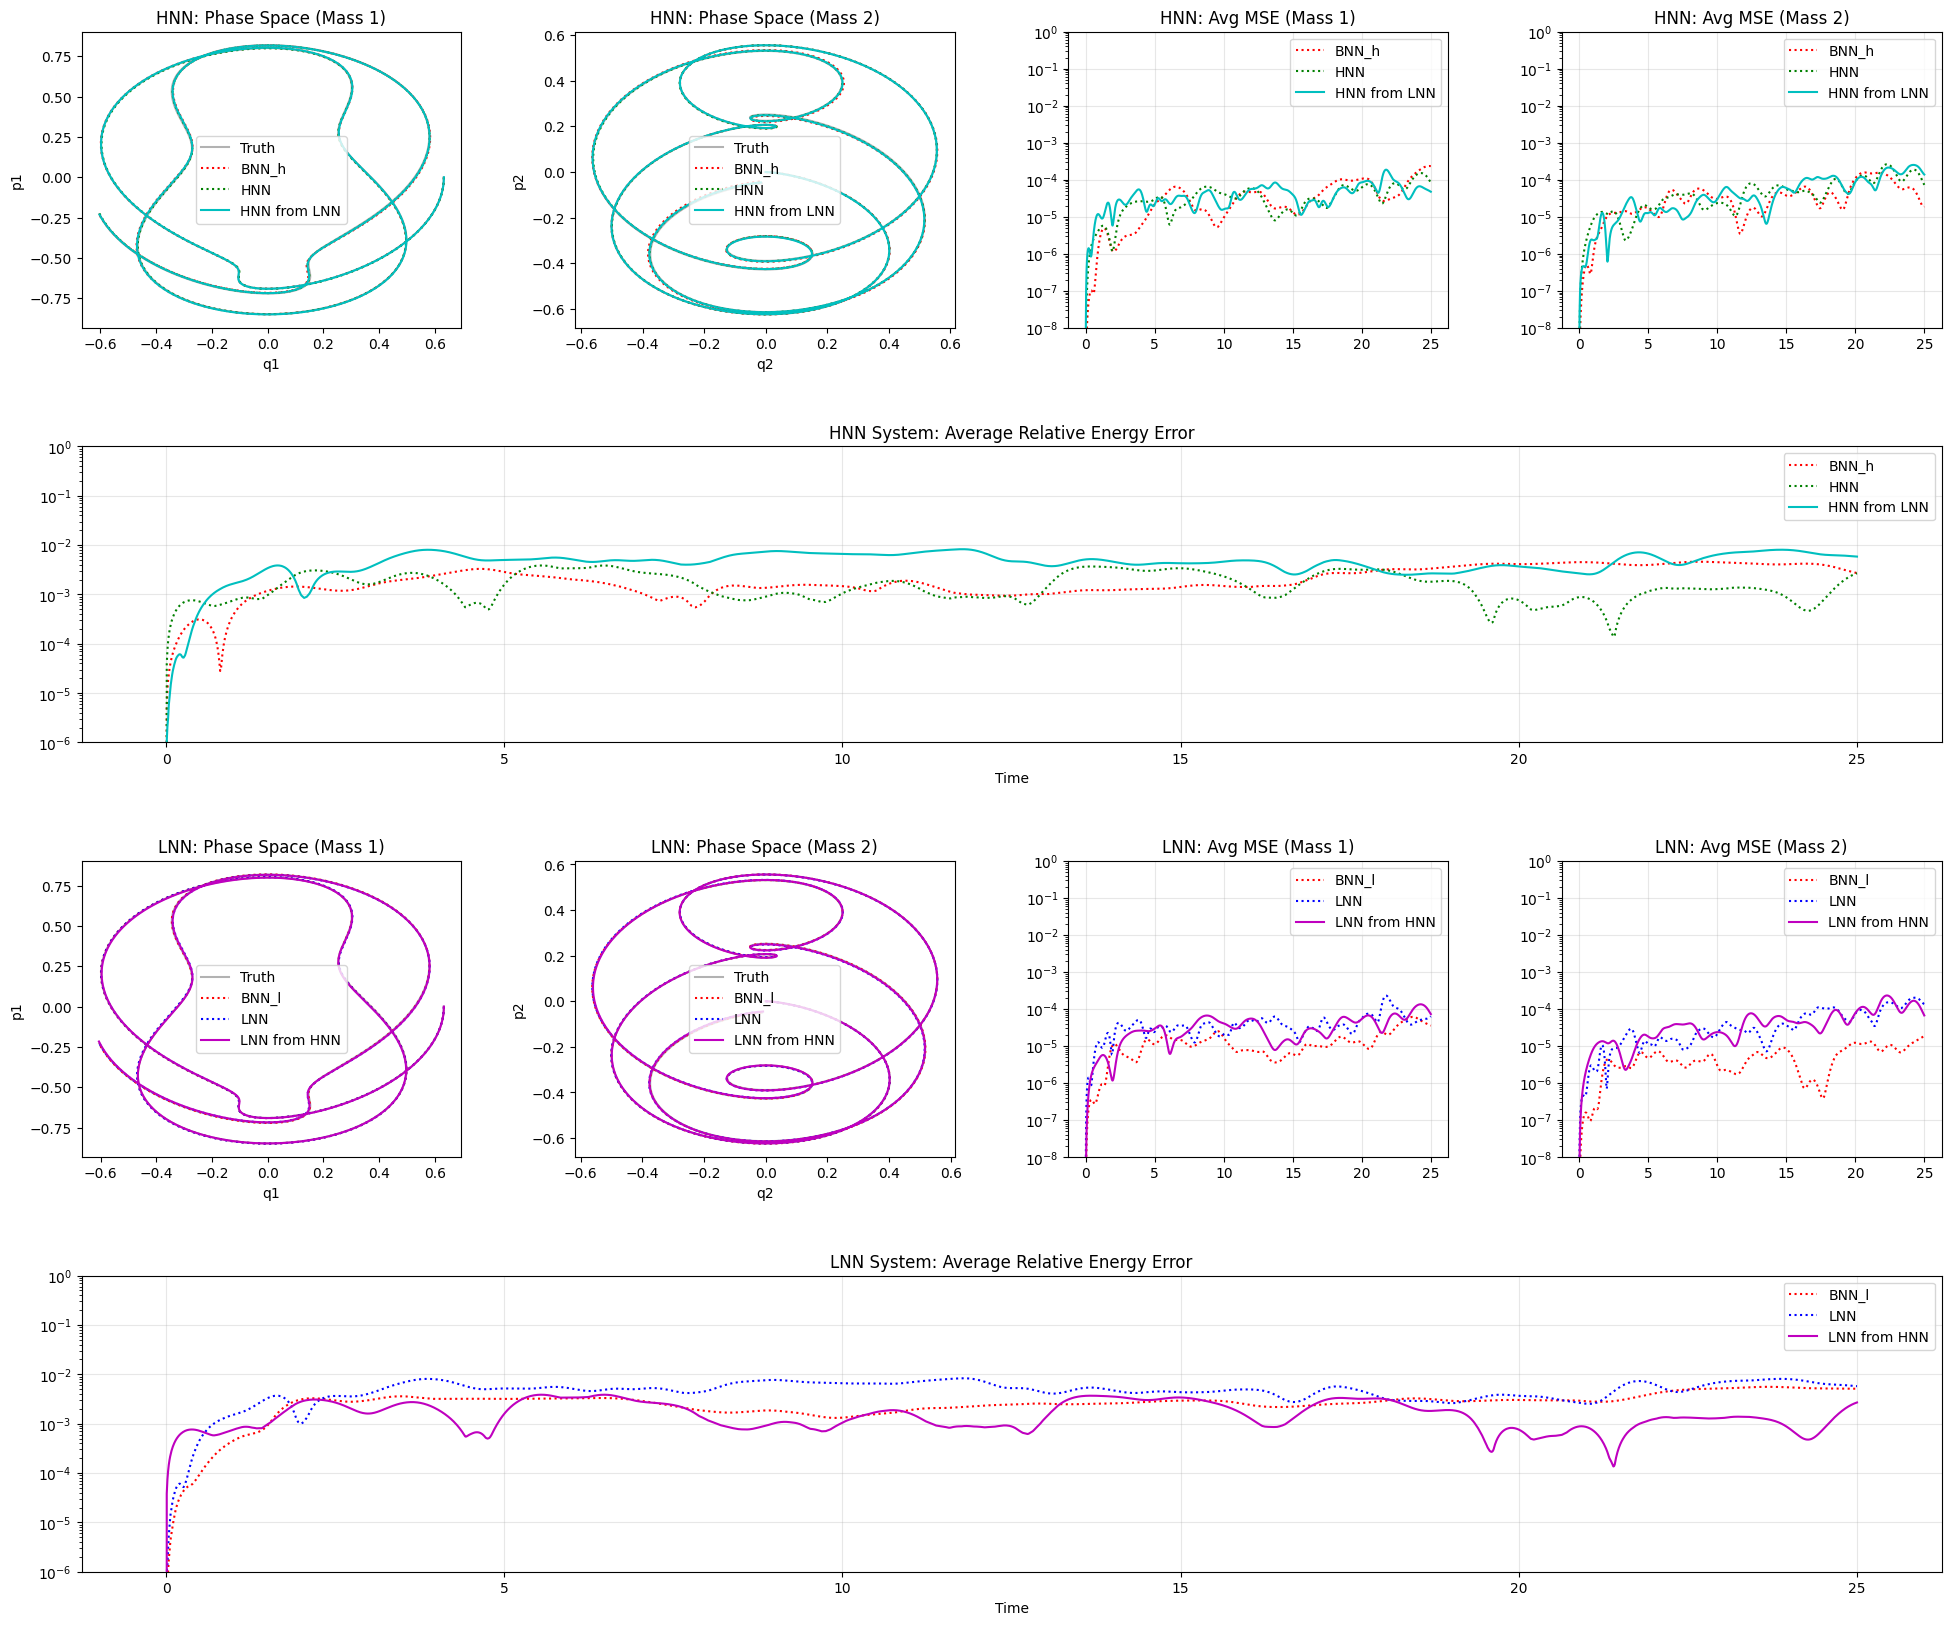

=== Extrapolation Plots ===


/var/folders/54/vv15yr8537zbdx1vcsrpv0sm0000gn/T/ipykernel_47295/4233645160.py:245: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


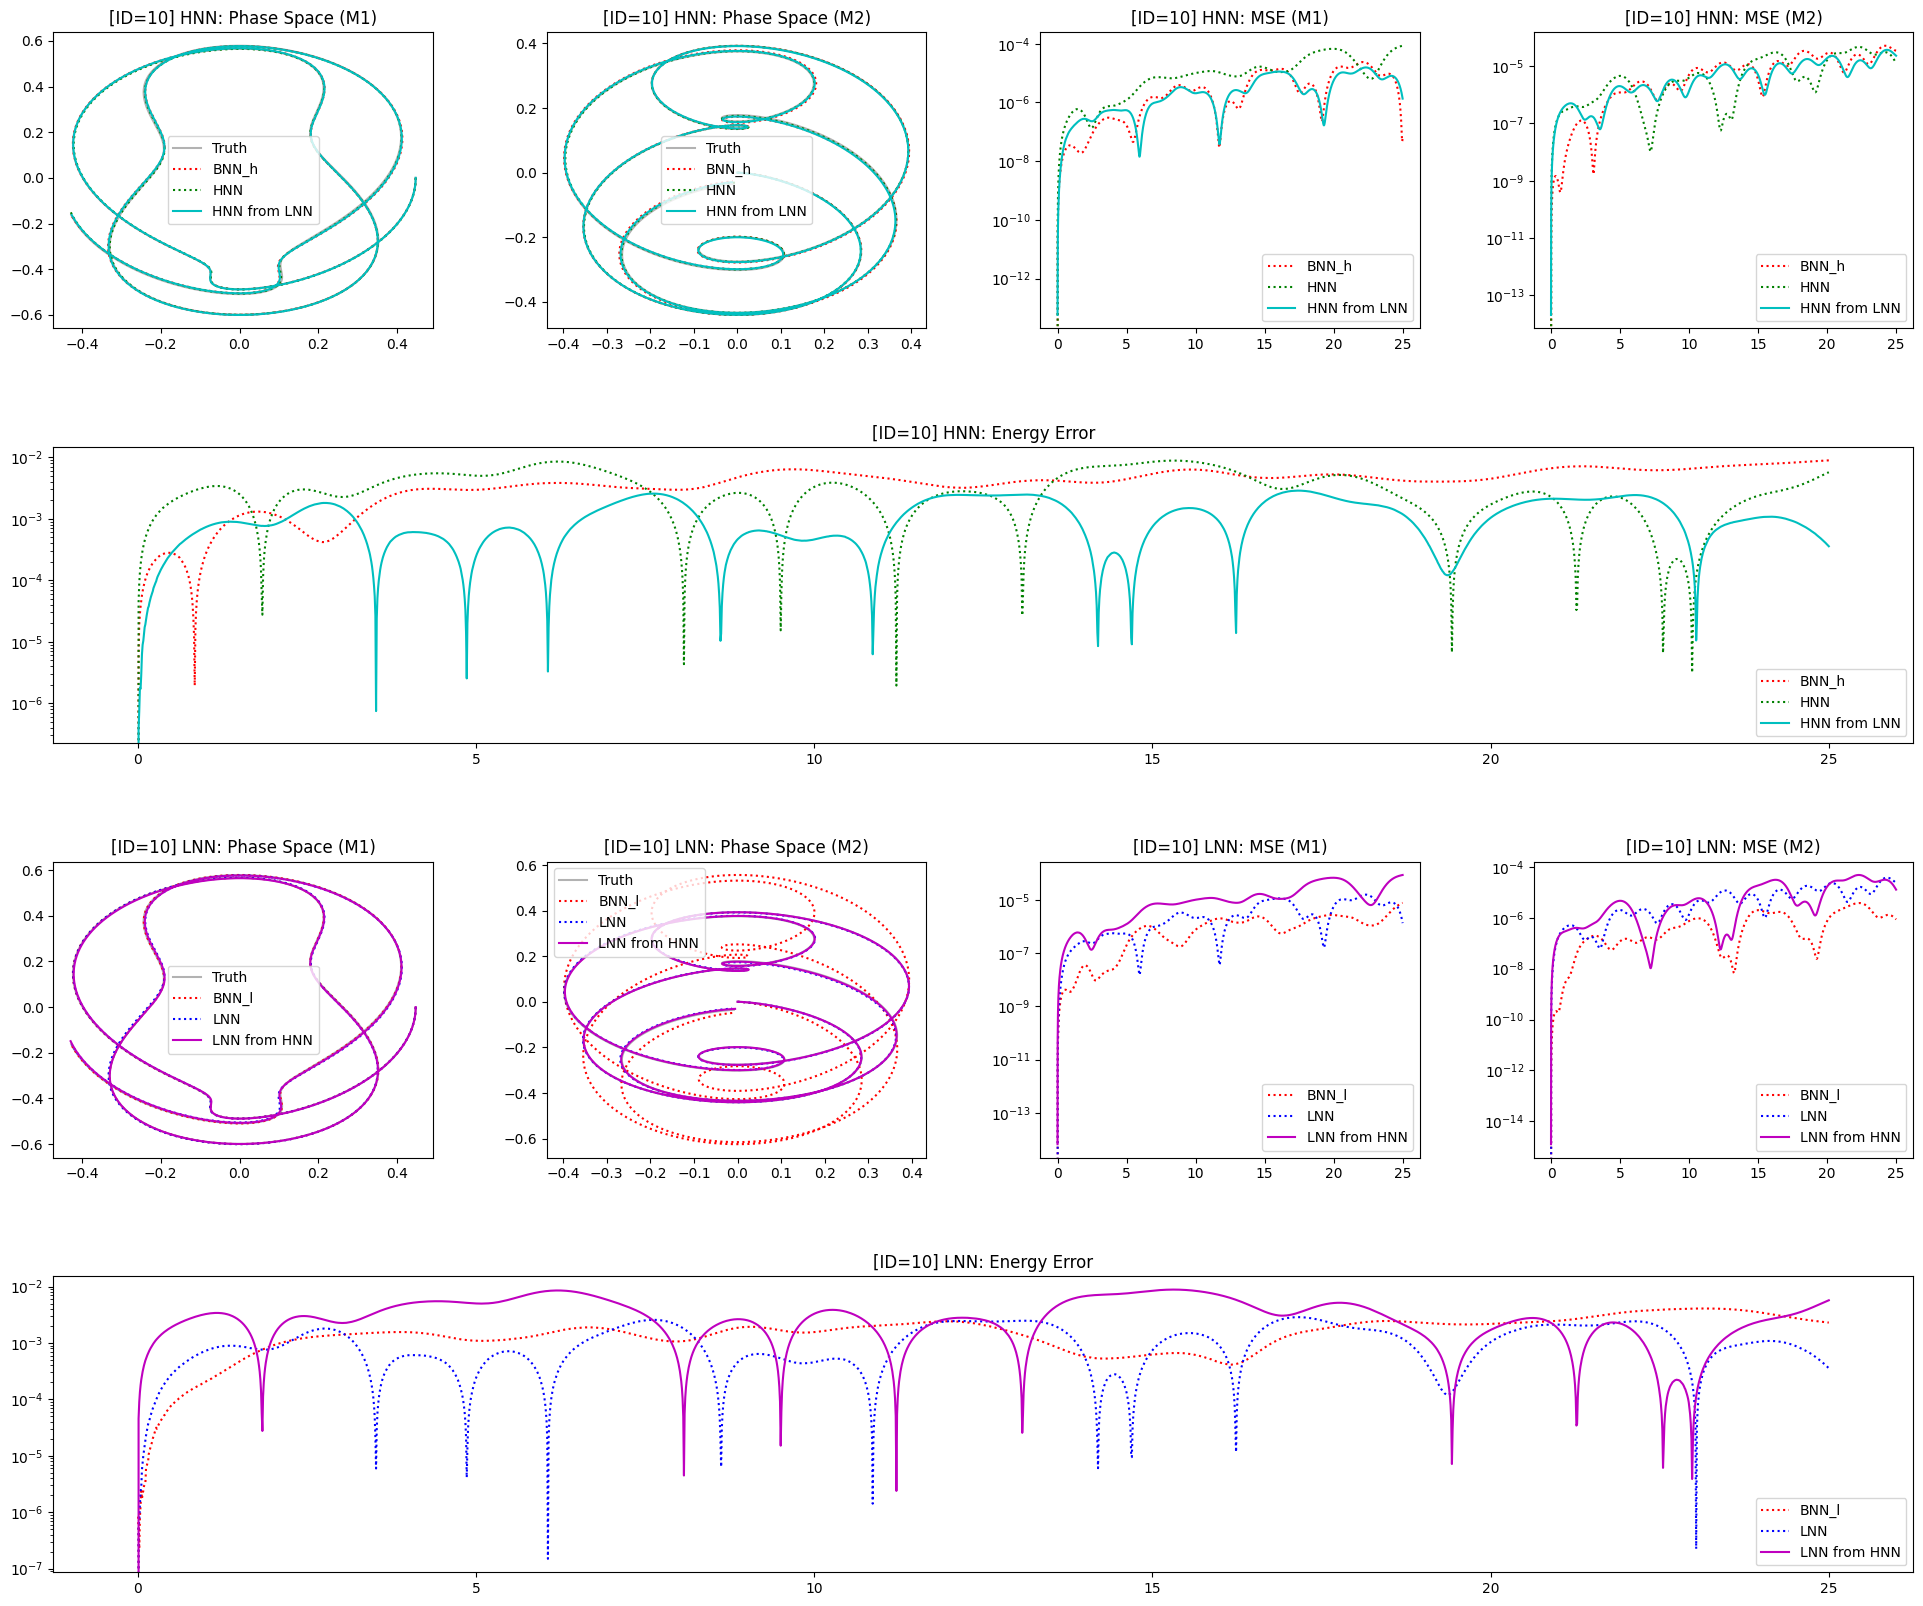

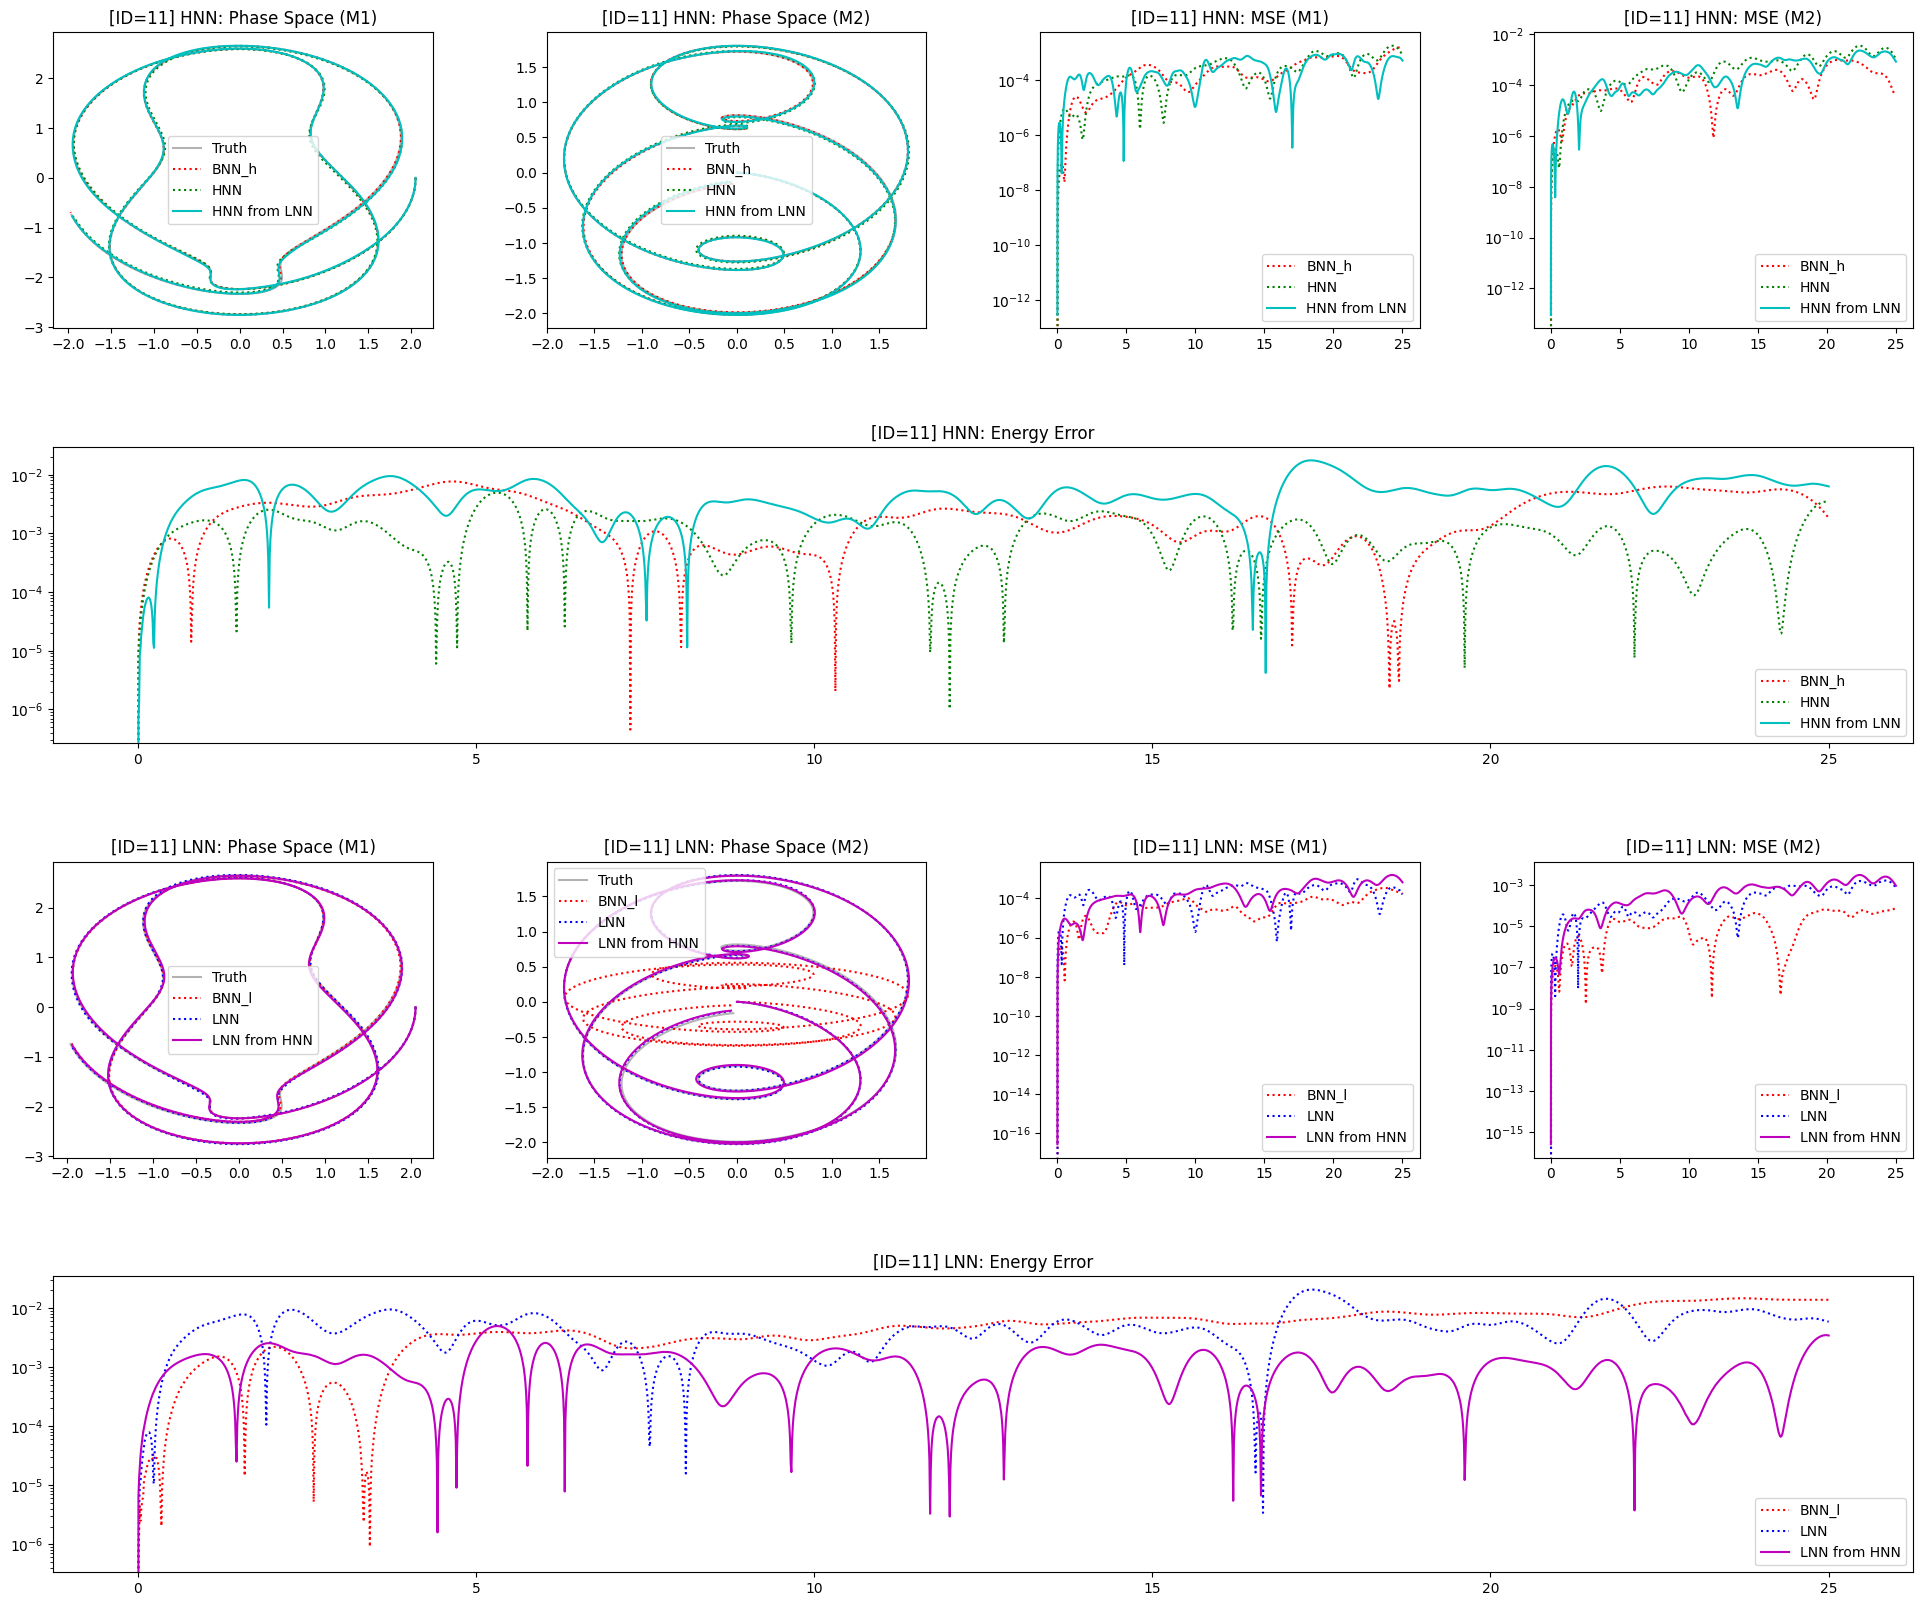

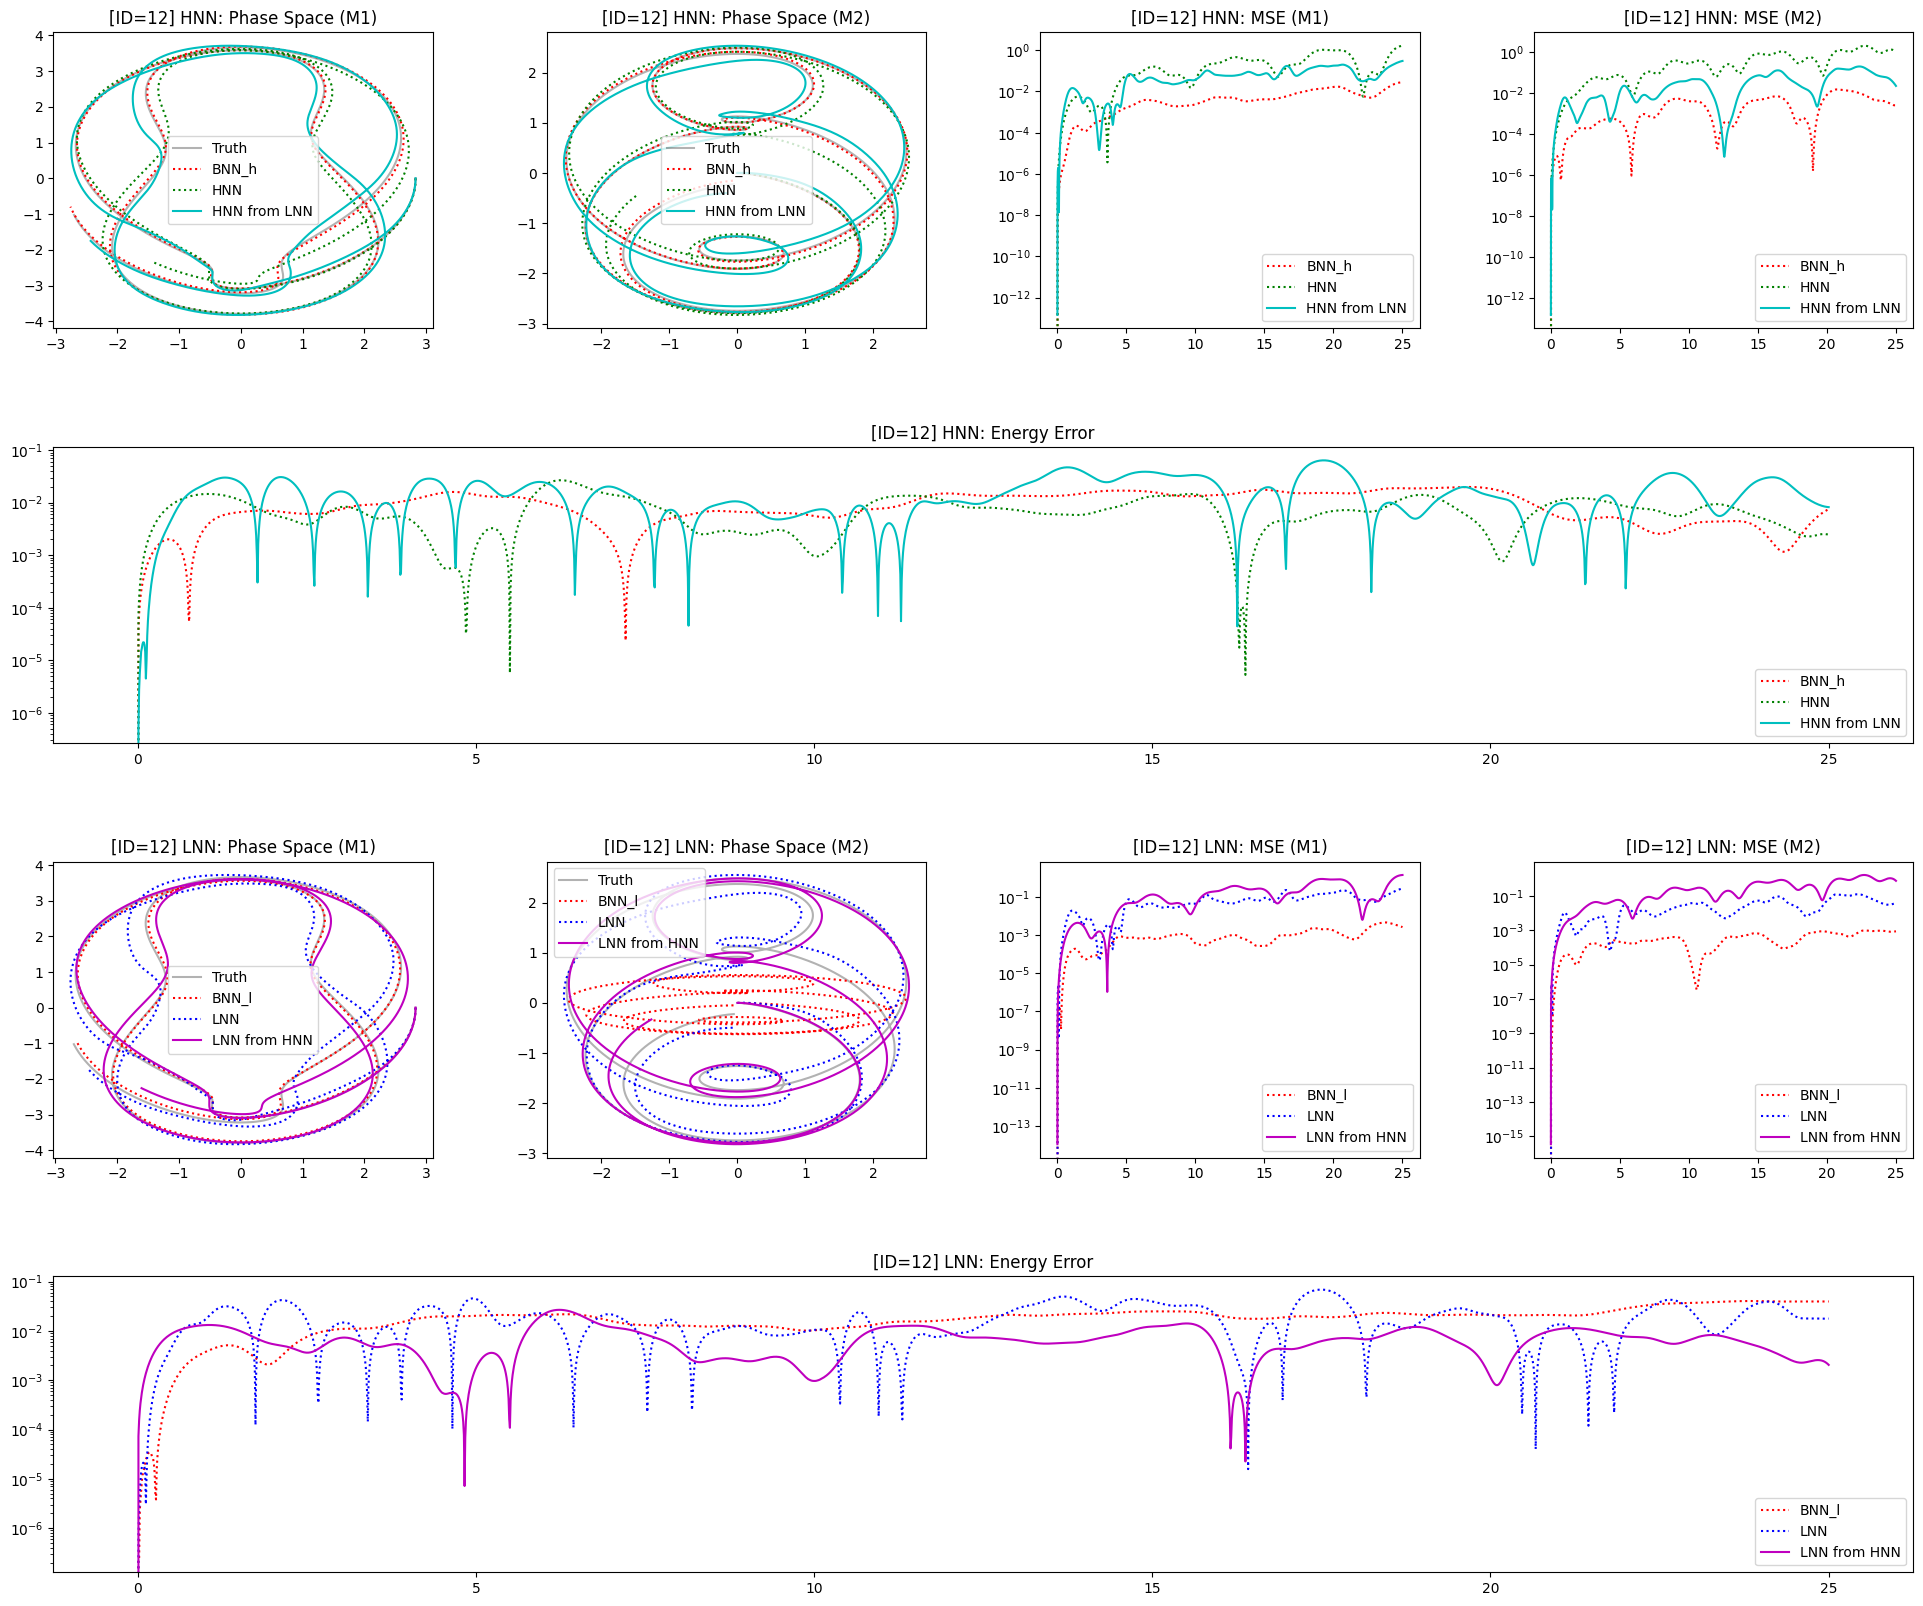

In [59]:
# --- レイアウト設定 ---
fig = plt.figure(figsize=(24, 20)) 
gs = gridspec.GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.3)

idx_plot = 0 # 代表軌道

# =========================================================
# Row 1: HNN System (Average Metrics & Rep. Phase Space)
# =========================================================
ax1 = fig.add_subplot(gs[0, 0]) # M1 Phase Space
ax2 = fig.add_subplot(gs[0, 1]) # M2 Phase Space
ax3 = fig.add_subplot(gs[0, 2]) # M1 MSE
ax4 = fig.add_subplot(gs[0, 3]) # M2 MSE

# 1-1. M1 Phase Space
ax1.plot(q_true[idx_plot, :, 0], p_true[idx_plot, :, 0], 'k-', label='Truth', alpha=0.3)
ax1.plot(q_bnn_h[idx_plot, :, 0], p_bnn_h[idx_plot, :, 0], 'r:', label='BNN_h') # 追加
ax1.plot(q_hnn[idx_plot, :, 0], p_hnn[idx_plot, :, 0], 'g:', label='HNN')
ax1.plot(q_hnn_from_lnn[idx_plot, :, 0], p_hnn_from_lnn[idx_plot, :, 0], 'c-', label='HNN from LNN')
ax1.set_title('HNN: Phase Space (Mass 1)')
ax1.set_xlabel('q1')
ax1.set_ylabel('p1')
ax1.legend()

# 1-2. M2 Phase Space
ax2.plot(q_true[idx_plot, :, 1], p_true[idx_plot, :, 1], 'k-', label='Truth', alpha=0.3)
ax2.plot(q_bnn_h[idx_plot, :, 1], p_bnn_h[idx_plot, :, 1], 'r:', label='BNN_h') # 追加
ax2.plot(q_hnn[idx_plot, :, 1], p_hnn[idx_plot, :, 1], 'g:', label='HNN')
ax2.plot(q_hnn_from_lnn[idx_plot, :, 1], p_hnn_from_lnn[idx_plot, :, 1], 'c-', label='HNN from LNN')
ax2.set_title('HNN: Phase Space (Mass 2)')
ax2.set_xlabel('q2')
ax2.set_ylabel('p2')
ax2.legend()

# 1-3. M1 Average MSE
ax3.plot(t_eval, mse_mean_bnn_h_m1, 'r:', label='BNN_h') # 追加
ax3.plot(t_eval, mse_mean_hnn_m1, 'g:', label='HNN')
ax3.plot(t_eval, mse_mean_hnn_fl_m1, 'c-', label='HNN from LNN')
ax3.set_title('HNN: Avg MSE (Mass 1)')
ax3.set_yscale('log')
ax3.set_ylim(1e-8, 1e0)
ax3.grid(True, alpha=0.3)
ax3.legend()

# 1-4. M2 Average MSE
ax4.plot(t_eval, mse_mean_bnn_h_m2, 'r:', label='BNN_h') # 追加
ax4.plot(t_eval, mse_mean_hnn_m2, 'g:', label='HNN')
ax4.plot(t_eval, mse_mean_hnn_fl_m2, 'c-', label='HNN from LNN')
ax4.set_title('HNN: Avg MSE (Mass 2)')
ax4.set_yscale('log')
ax4.set_ylim(1e-8, 1e0)
ax4.grid(True, alpha=0.3)
ax4.legend()


# =========================================================
# Row 2: HNN System Energy Error
# =========================================================
ax5 = fig.add_subplot(gs[1, 0:4])

ax5.plot(t_eval, err_mean_bnn_h, 'r:', label='BNN_h') # 追加
ax5.plot(t_eval, err_mean_hnn, 'g:', label='HNN')
ax5.plot(t_eval, err_mean_hnn_fl, 'c-', label='HNN from LNN')
ax5.set_title('HNN System: Average Relative Energy Error')
ax5.set_xlabel('Time')
ax5.set_yscale('log')
ax5.set_ylim(1e-6, 1e0)
ax5.grid(True, alpha=0.3)
ax5.legend()


# =========================================================
# Row 3: LNN System (Average Metrics & Rep. Phase Space)
# =========================================================
ax6 = fig.add_subplot(gs[2, 0]) # M1 Phase Space
ax7 = fig.add_subplot(gs[2, 1]) # M2 Phase Space
ax8 = fig.add_subplot(gs[2, 2]) # M1 MSE
ax9 = fig.add_subplot(gs[2, 3]) # M2 MSE

# 3-1. M1 Phase Space
ax6.plot(q_true[idx_plot, :, 0], p_true[idx_plot, :, 0], 'k-', label='Truth', alpha=0.3)
ax6.plot(q_bnn_l[idx_plot, :, 0], p_bnn_l[idx_plot, :, 0], 'r:', label='BNN_l') # 追加
ax6.plot(q_lnn[idx_plot, :, 0], p_lnn[idx_plot, :, 0], 'b:', label='LNN')
ax6.plot(q_lnn_from_hnn[idx_plot, :, 0], p_lnn_from_hnn[idx_plot, :, 0], 'm-', label='LNN from HNN')
ax6.set_title('LNN: Phase Space (Mass 1)')
ax6.set_xlabel('q1')
ax6.set_ylabel('p1')
ax6.legend()

# 3-2. M2 Phase Space
ax7.plot(q_true[idx_plot, :, 1], p_true[idx_plot, :, 1], 'k-', label='Truth', alpha=0.3)
ax7.plot(q_bnn_l[idx_plot, :, 1], p_bnn_l[idx_plot, :, 1], 'r:', label='BNN_l') # 追加
ax7.plot(q_lnn[idx_plot, :, 1], p_lnn[idx_plot, :, 1], 'b:', label='LNN')
ax7.plot(q_lnn_from_hnn[idx_plot, :, 1], p_lnn_from_hnn[idx_plot, :, 1], 'm-', label='LNN from HNN')
ax7.set_title('LNN: Phase Space (Mass 2)')
ax7.set_xlabel('q2')
ax7.set_ylabel('p2')
ax7.legend()

# 3-3. M1 Average MSE
ax8.plot(t_eval, mse_mean_bnn_l_m1, 'r:', label='BNN_l') # 追加
ax8.plot(t_eval, mse_mean_lnn_m1, 'b:', label='LNN')
ax8.plot(t_eval, mse_mean_lnn_fh_m1, 'm-', label='LNN from HNN')
ax8.set_title('LNN: Avg MSE (Mass 1)')
ax8.set_yscale('log')
ax8.set_ylim(1e-8, 1e0)
ax8.grid(True, alpha=0.3)
ax8.legend()

# 3-4. M2 Average MSE
ax9.plot(t_eval, mse_mean_bnn_l_m2, 'r:', label='BNN_l') # 追加
ax9.plot(t_eval, mse_mean_lnn_m2, 'b:', label='LNN')
ax9.plot(t_eval, mse_mean_lnn_fh_m2, 'm-', label='LNN from HNN')
ax9.set_title('LNN: Avg MSE (Mass 2)')
ax9.set_yscale('log')
ax9.set_ylim(1e-8, 1e0)
ax9.grid(True, alpha=0.3)
ax9.legend()


# =========================================================
# Row 4: LNN System Energy Error
# =========================================================
ax10 = fig.add_subplot(gs[3, 0:4])

ax10.plot(t_eval, err_mean_bnn_l, 'r:', label='BNN_l') # 追加
ax10.plot(t_eval, err_mean_lnn, 'b:', label='LNN')
ax10.plot(t_eval, err_mean_lnn_fh, 'm-', label='LNN from HNN')
ax10.set_title('LNN System: Average Relative Energy Error')
ax10.set_xlabel('Time')
ax10.set_yscale('log')
ax10.set_ylim(1e-6, 1e0)
ax10.grid(True, alpha=0.3)
ax10.legend()

plt.tight_layout()
plt.show()


# =========================================================
# 外挿データ (Extrapolation) の個別プロット
# =========================================================
print("=== Extrapolation Plots ===")
num_total_traj = q_true.shape[0]
extrap_indices = range(N_interp, num_total_traj)

for idx in extrap_indices:
    fig = plt.figure(figsize=(24, 20))
    gs = gridspec.GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.3)
    
    # --- Row 1: HNN [M1 pq, M2 pq, M1 MSE, M2 MSE] ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[0, 3])
    
    # M1 pq
    ax1.plot(q_true[idx, :, 0], p_true[idx, :, 0], 'k-', label='Truth', alpha=0.3)
    ax1.plot(q_bnn_h[idx, :, 0], p_bnn_h[idx, :, 0], 'r:', label='BNN_h') # 追加
    ax1.plot(q_hnn[idx, :, 0], p_hnn[idx, :, 0], 'g:', label='HNN')
    ax1.plot(q_hnn_from_lnn[idx, :, 0], p_hnn_from_lnn[idx, :, 0], 'c-', label='HNN from LNN')
    ax1.set_title(f'[ID={idx}] HNN: Phase Space (M1)')
    ax1.legend()
    
    # M2 pq
    ax2.plot(q_true[idx, :, 1], p_true[idx, :, 1], 'k-', label='Truth', alpha=0.3)
    ax2.plot(q_bnn_h[idx, :, 1], p_bnn_h[idx, :, 1], 'r:', label='BNN_h') # 追加
    ax2.plot(q_hnn[idx, :, 1], p_hnn[idx, :, 1], 'g:', label='HNN')
    ax2.plot(q_hnn_from_lnn[idx, :, 1], p_hnn_from_lnn[idx, :, 1], 'c-', label='HNN from LNN')
    ax2.set_title(f'[ID={idx}] HNN: Phase Space (M2)')
    ax2.legend()
    
    # M1 MSE
    ax3.plot(t_eval, mse_bnn_h_m1[idx], 'r:', label='BNN_h') # 追加
    ax3.plot(t_eval, mse_hnn_m1[idx], 'g:', label='HNN')
    ax3.plot(t_eval, mse_hnn_from_lnn_m1[idx], 'c-', label='HNN from LNN')
    ax3.set_yscale('log')
    ax3.set_title(f'[ID={idx}] HNN: MSE (M1)')
    ax3.legend()
    
    # M2 MSE
    ax4.plot(t_eval, mse_bnn_h_m2[idx], 'r:', label='BNN_h') # 追加
    ax4.plot(t_eval, mse_hnn_m2[idx], 'g:', label='HNN')
    ax4.plot(t_eval, mse_hnn_from_lnn_m2[idx], 'c-', label='HNN from LNN')
    ax4.set_yscale('log')
    ax4.set_title(f'[ID={idx}] HNN: MSE (M2)')
    ax4.legend()
    
    # --- Row 2: HNN Energy ---
    ax5 = fig.add_subplot(gs[1, 0:4])
    ax5.plot(t_eval, err_E_bnn_h[idx], 'r:', label='BNN_h') # 追加
    ax5.plot(t_eval, err_E_hnn[idx], 'g:', label='HNN')
    ax5.plot(t_eval, err_E_hnn_from_lnn[idx], 'c-', label='HNN from LNN')
    ax5.set_yscale('log')
    ax5.set_title(f'[ID={idx}] HNN: Energy Error')
    ax5.legend()
    
    # --- Row 3: LNN [M1 pq, M2 pq, M1 MSE, M2 MSE] ---
    ax6 = fig.add_subplot(gs[2, 0])
    ax7 = fig.add_subplot(gs[2, 1])
    ax8 = fig.add_subplot(gs[2, 2])
    ax9 = fig.add_subplot(gs[2, 3])
    
    # M1 pq
    ax6.plot(q_true[idx, :, 0], p_true[idx, :, 0], 'k-', label='Truth', alpha=0.3)
    ax6.plot(q_bnn_l[idx, :, 0], p_bnn_l[idx, :, 0], 'r:', label='BNN_l') # 追加
    ax6.plot(q_lnn[idx, :, 0], p_lnn[idx, :, 0], 'b:', label='LNN')
    ax6.plot(q_lnn_from_hnn[idx, :, 0], p_lnn_from_hnn[idx, :, 0], 'm-', label='LNN from HNN')
    ax6.set_title(f'[ID={idx}] LNN: Phase Space (M1)')
    ax6.legend()
    
    # M2 pq
    ax7.plot(q_true[idx, :, 1], p_true[idx, :, 1], 'k-', label='Truth', alpha=0.3)
    ax7.plot(q_bnn_l[idx, :, 1], p_bnn_l[idx_plot, :, 1], 'r:', label='BNN_l') # 追加
    ax7.plot(q_lnn[idx, :, 1], p_lnn[idx, :, 1], 'b:', label='LNN')
    ax7.plot(q_lnn_from_hnn[idx, :, 1], p_lnn_from_hnn[idx, :, 1], 'm-', label='LNN from HNN')
    ax7.set_title(f'[ID={idx}] LNN: Phase Space (M2)')
    ax7.legend()
    
    # M1 MSE
    ax8.plot(t_eval, mse_bnn_l_m1[idx], 'r:', label='BNN_l') # 追加
    ax8.plot(t_eval, mse_lnn_m1[idx], 'b:', label='LNN')
    ax8.plot(t_eval, mse_lnn_from_hnn_m1[idx], 'm-', label='LNN from HNN')
    ax8.set_yscale('log')
    ax8.set_title(f'[ID={idx}] LNN: MSE (M1)')
    ax8.legend()
    
    # M2 MSE
    ax9.plot(t_eval, mse_bnn_l_m2[idx], 'r:', label='BNN_l') # 追加
    ax9.plot(t_eval, mse_lnn_m2[idx], 'b:', label='LNN')
    ax9.plot(t_eval, mse_lnn_from_hnn_m2[idx], 'm-', label='LNN from HNN')
    ax9.set_yscale('log')
    ax9.set_title(f'[ID={idx}] LNN: MSE (M2)')
    ax9.legend()
    
    # --- Row 4: LNN Energy ---
    ax10 = fig.add_subplot(gs[3, 0:4])
    ax10.plot(t_eval, err_E_bnn_l[idx], 'r:', label='BNN_l') # 追加
    ax10.plot(t_eval, err_E_lnn[idx], 'b:', label='LNN')
    ax10.plot(t_eval, err_E_lnn_from_hnn[idx], 'm-', label='LNN from HNN')
    ax10.set_yscale('log')
    ax10.set_title(f'[ID={idx}] LNN: Energy Error')
    ax10.legend()
    
    plt.tight_layout()
    plt.show()